# Toy Experiments

In [1]:
import os, sys
sys.path.append("..")

from src import distributions

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
X_sampler = distributions.StandardNormalSampler(dim=2, device="cuda")
Y_sampler = distributions.SwissRollSampler(device="cuda")
# Y_sampler = distributions.Mix8GaussiansSampler(std=0.1, r=np.sqrt(2), device="cuda")

DIM = 2
H = 100

batch_size = 1000
lr = 1e-4
n_steps = 100
GAMMA = 0.0
G_ITERS = 10
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 20000


ZC = 1
Z_STD = 1.0

In [3]:
def train(X_sampler, Y_sampler, denoiser, denoiser_opt, G, G_opt, D, D_opt, sde, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):
            
        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = X_sampler.sample(batch_size)
                Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
                xN = G(x0)
                
                t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((denoiser(xt, t) - xN) ** 2).mean()
                denoiser_opt.zero_grad(); f_loss.backward(); denoiser_opt.step()

            x0 = X_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(x0)

            t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_x_t = (denoiser(xt, t) - xt)
            E = (xN - xt)
            
            G_loss = (f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2 - D(xN).mean()
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()
        
        
        # plotter 1
        if step % 500 == 0:
            clear_output(wait=True)
            
            fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=10)
            plt.show()
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = X_sampler.sample(plot_n_samples)
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(X).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            sde_mse.append(F.mse_loss(X.detach().cpu(), f_dataset).item())
            print('G mse:', G_mse[-1])
            print('sde mse:', sde_mse[-1])
            
            with torch.no_grad():
                X = X_sampler.sample(1000)

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    Z = torch.randn(1000, ZC, device='cuda') * Z_STD
                    T_XZ_np.append(G(X).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])

                T_X_np = []
                for i in range(100):
                    T_X_np.append(sde(X).cpu().numpy())
            
                T_X_np = np.array(T_X_np)
                sde_var.append(T_X_np.var(axis=0).mean(axis=0).mean().item())
                print('sde var:', sde_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
            
        for D_iter in range(D_ITERS):    
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(x0)
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

## 4. Training

In [4]:
f = ScoreNetwork().cuda()
denoiser = ScoreNetwork().cuda()

G = nn.Sequential(
    nn.Linear(DIM+ZC, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM)
).cuda()

class G_wrapper(nn.Module):
    def __init__(self, G, zc, z_std):
        super().__init__()
        self.G = G
        self.zc = zc
        self.z_std = z_std
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def forward(self, x0):
        Z = torch.randn((x0.shape[0], self.zc)).to(self.device) * self.z_std
        xN = self.G(torch.cat([x0, Z], axis = -1))
        return xN
    
G = G_wrapper(G, 1, 1.0)

D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1)
).cuda()

f_opt = Adam(f.parameters(), lr=lr)
G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)
denoiser_opt = Adam(denoiser.parameters(), lr=lr)



class SDE(nn.Module):
    def __init__(self, denoiser, n_steps):
        super().__init__()
        self.denoiser = denoiser
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0, traj = False):
        x, t = x0, 0.0
        trajectory = [x]
        for step in range(self.n_steps):
            batch_size = x.shape[0]
            if step < self.n_steps-1:
                x = x + self.delta_t*(self.denoiser(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) - x)/(1-torch.tensor(t).repeat(batch_size)[:, None].cuda()) + torch.randn_like(x)*np.sqrt(GAMMA*self.delta_t)
            else:
                x = x + self.delta_t*(self.denoiser(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) - x)/(1-torch.tensor(t).repeat(batch_size)[:, None].cuda())
            t += self.delta_t
            trajectory.append(x)
        if traj:
            return x, trajectory
        return x

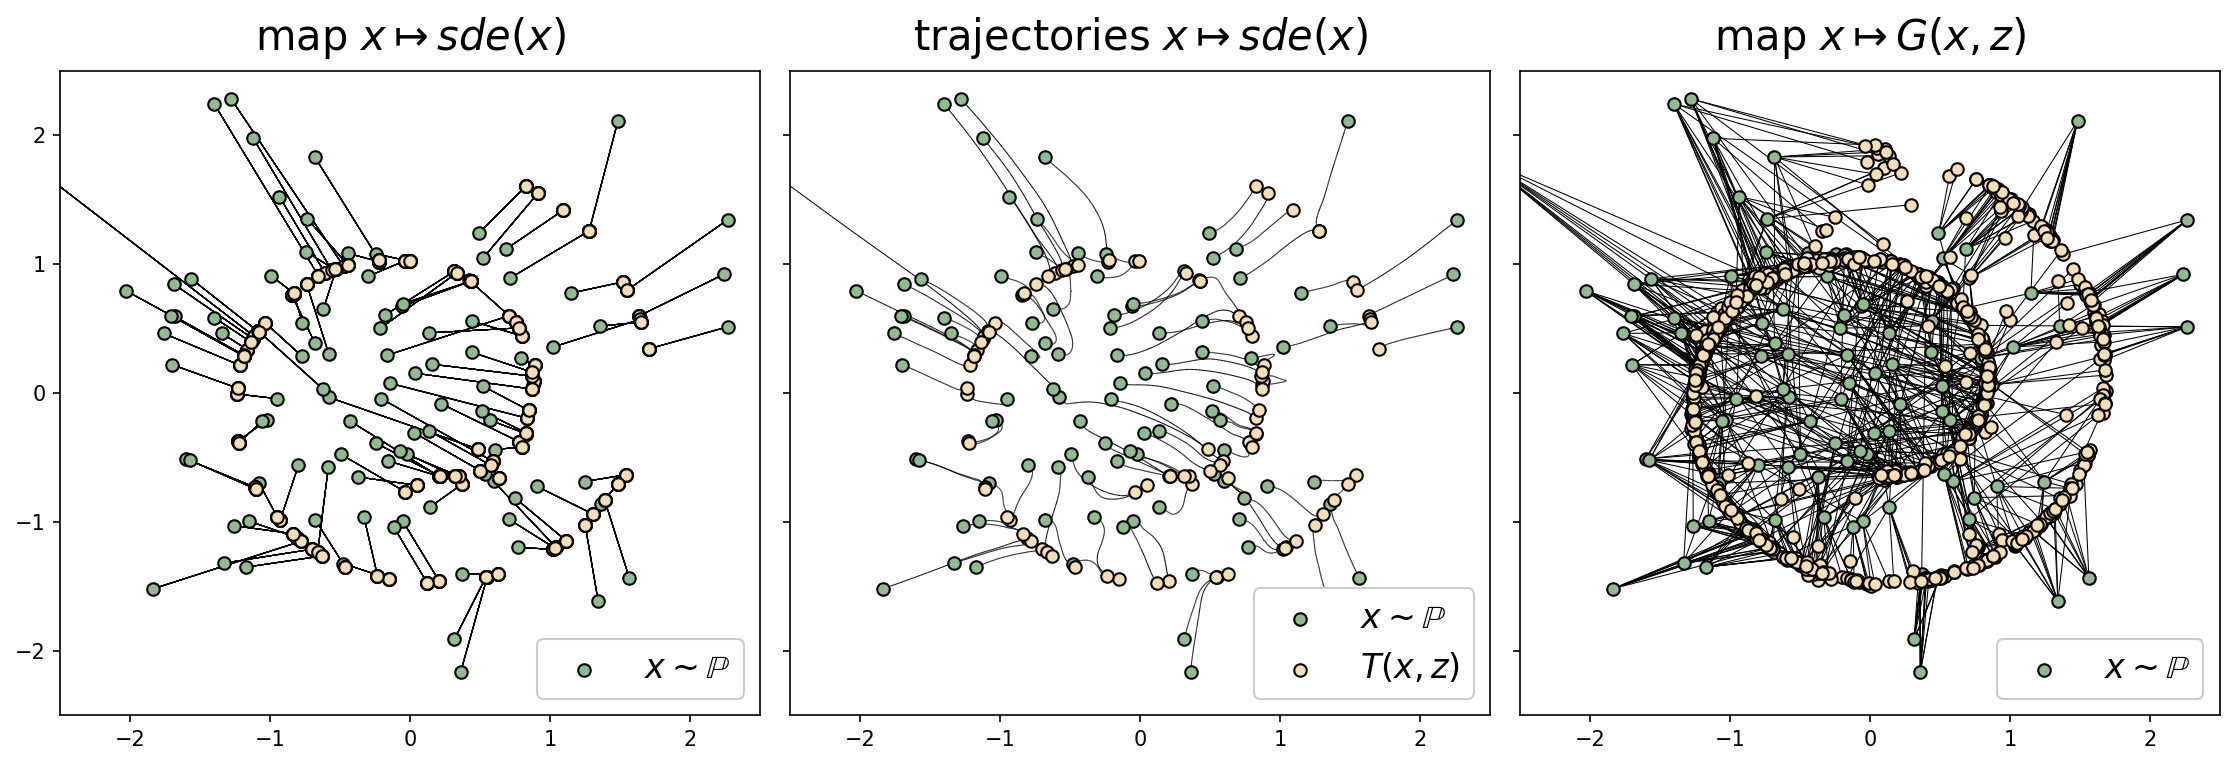

G mse: 0.33472076058387756
sde mse: 0.17100147902965546
G var: 0.19369974732398987
sde var: 4.4491840767157953e-13


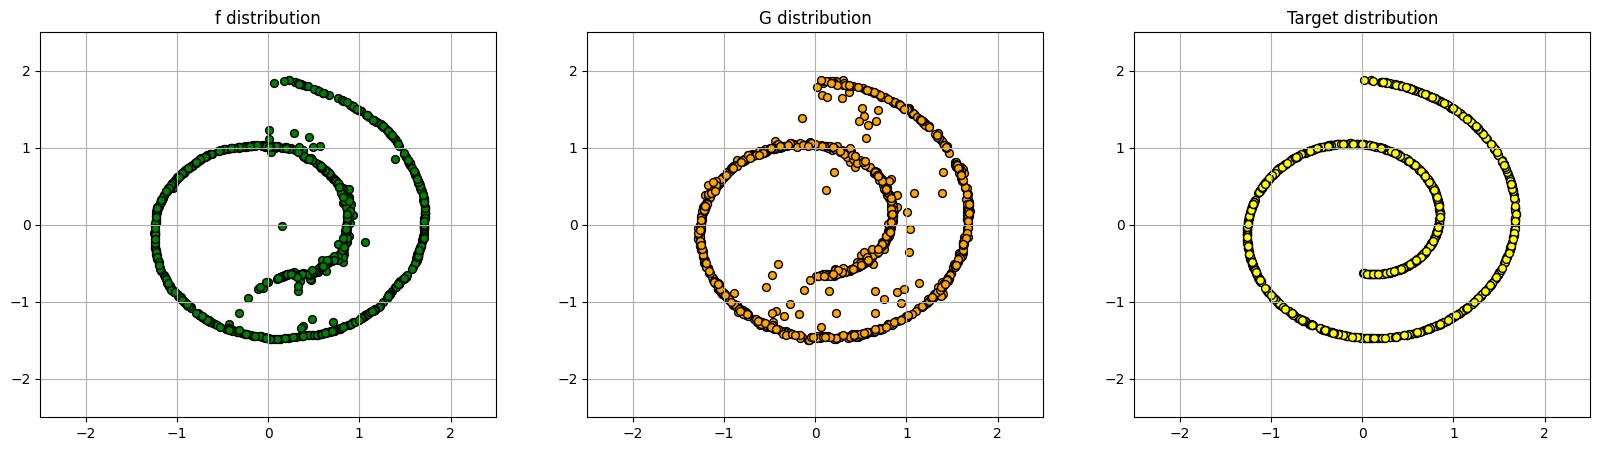

 10%|█         | 2058/20000 [02:12<19:11, 15.58it/s]  


KeyboardInterrupt: 

In [5]:
sde = SDE(denoiser=denoiser, n_steps=n_steps).cuda()
stats = train(X_sampler, Y_sampler, denoiser, denoiser_opt, G, G_opt, D, D_opt, sde, plot_n_samples=1000)

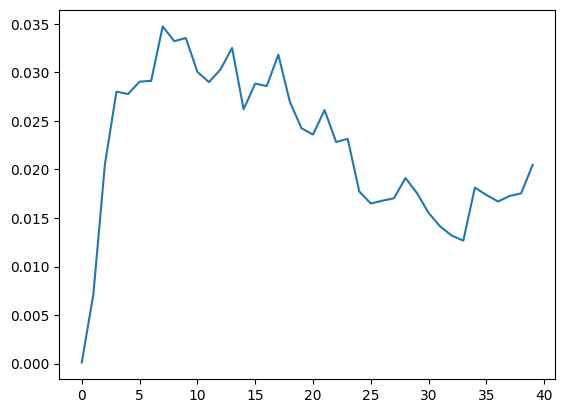

In [ ]:
G_mse, G_var, sde_mse, sde_var = stats
plt.plot(np.arange(len(G_var)), np.array(G_var))